<a href="https://colab.research.google.com/github/AntonioSanabria26/FisicaComputacional1/blob/master/Actividad6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BIBLIOTECAS UTILIZADAS**

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

# **DATAFRAME METEOROLOGICO**

In [ ]:
#----------- LEYENDO EL URL, DONDE EL ARCHIVO ESTA EN FORMATO CSV -------------#

URL = "https://raw.githubusercontent.com/AntonioSanabria26/FisicaComputacional1/master/Actividad1/26179.csv"
df = pd.read_csv( URL )

#--------------------------- ESTRUCTURA DEL TEXTO -----------------------------#

df = df.drop(range(0,17),axis=0)
df = df.drop([8108,8109])
# ELIMINACIÓN DE LAS PRIMERAS 17 LINEAS
df = df.dropna() 
# ELIMINACION DE LAS FILAS CON N/A
df = df.replace(to_replace= "Nulo" ,value = "N/A",regex= True )
# REMPLAZANDO LOS "Nulo" , por N/A

df = df["CNA-SMN-CG-GMC-SMAA-CLIMATOLOGIA"].str.split("\s+", n=5, expand=True)
#SEPARANDO LA CADENA DE TEXTO EN 5 COLUMNAS, CON SPLIT DE ESPACIO+, PARA QUE
#PUEDA TOMAR VALORES ENCIMA DE 1 ESPACIO DE LA MEMORIA

df.columns = ['Fecha', 'Precipitacion', 'Evaporacion', 'Tmax', 'Tmin']
#NOMBRE DE LAS COLUMNAS

df_columns =['Precipitacion', 'Evaporacion', 'Tmax', 'Tmin']
for i in df_columns:
  df[i] = pd.to_numeric( df[i] ,errors = "coerce")
#CONVIRTIENDO LAS COLUMNAS df_columns A FLOTANTES

df["Fecha"] = pd.to_datetime(df["Fecha"],dayfirst=True).copy()
df["Año"] = df["Fecha"].dt.year
df["Mes"] =df["Fecha"].dt.month
# CONVIRTIENDO LA FECHA 

df.drop('Mes', axis=1, inplace=True)
df['Mes'] = df['Fecha'].dt.strftime('%b')
# CONVIRTIENDO LOS MESES A CARACTERES

df = df.set_index("Fecha")
df = df.fillna(method='ffill')
#CONVIRTIENDO LA FECHA COMO SERIE DE TIEMPO


df_60 = df[(df['Año'] >= 1960) & (df['Año'] < 1990)]
df_90 = df[(df['Año'] >= 1990) & (df['Año'] < 2018)]
#DF DE 30 AÑOS


# **PRUEBA AUMENTADA DE DICKEY-FULLER (ADF) TMAX**

In [ ]:
#PRUEBA DE ESTACIONARIDAD DE UNA SERIE DE TIEMPO "TIME SERIES"
#DEFINICION DE LA FUCION PARA HACER LA PRUEBA

def test_stationarity(df_ts):

#SE DETERMIAN LA ESTADISTICA DE LOS PROMEDIOS MOVILES
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
#SE DEFINE EL TAMAÑO DE LA FIGURA
    plt.rcParams["figure.figsize"] = (12,6)

#GRAFICAMOS LA ESTADISTICA MOVIL
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
#REALIZACION DE LA PRUEBA AUMENTADA DICKEY-FULLER
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value',
                                '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
#SE CREA LA SERIE DE TIEMPO A ANALIZAR, DONDE SE PUEDE REGRESAR
#A ESTE PUNTO TANTAS VECES SEA NECESARIA REDIFINIR

#FECHA DE INICIO Y DE FIN:
start, end = '2013-01', '2016-01'
ts_90 = df_90.loc[start:end].copy()
ts_90.head()

,Precipitacion,Evaporacion,Tmax,Tmin,Año,Mes
Fecha,,,,,,
2013-01-01,0.0,8.1,18.0,2.5,2013,Jan
2013-01-02,0.0,8.1,17.0,1.5,2013,Jan
2013-01-03,0.0,8.1,20.0,2.0,2013,Jan
2013-01-04,0.0,8.1,19.0,3.0,2013,Jan
2013-01-05,0.0,8.1,20.5,5.0,2013,Jan


In [ ]:
# DEFINIMOS LA SEIRE DE TIEMPO PARA TMAX QUE VAMOS A ESTUDIAR.
# DEFINIDA CON NOMBRE GENERICO.

ts_test = ts_90['Tmax'].copy()

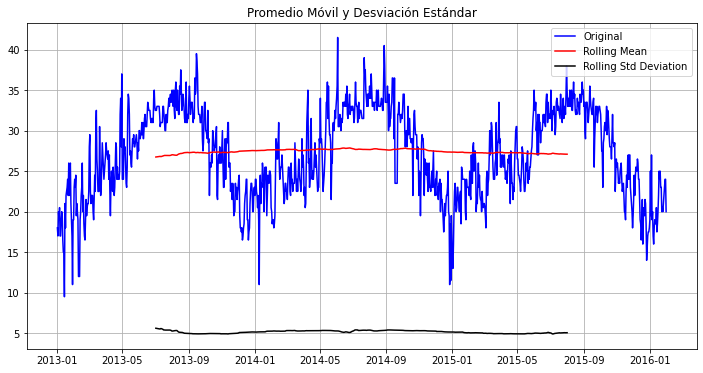

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.319042
p-value                           0.165900
#Lags Used                       14.000000
Number of Observations Used    1110.000000
Critical Value (1%)              -3.436255
Critical Value (5%)              -2.864147
Critical Value (10%)             -2.568158
dtype: float64


In [ ]:
#PRUEBA DE ESTACIONARIDAD DE TMAX
test_stationarity(ts_test)

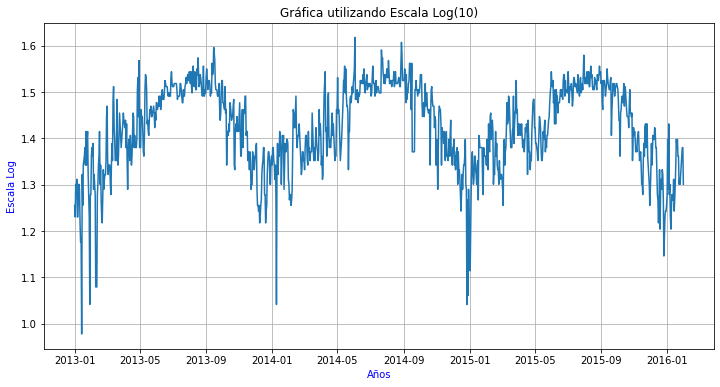

In [ ]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_log = np.log10(ts_test)
plt.plot(ts_test_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

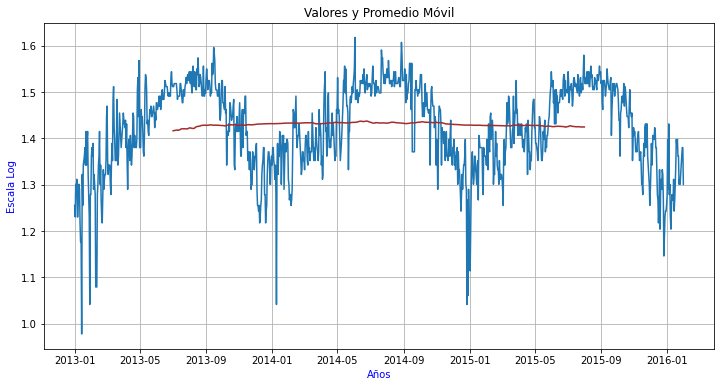

In [ ]:
# VAMOS A CALCULAR EL PROMEDIO MOVIL DE ts_test_log CON VENTANA DE 365
# PARA VER EL CONTRASTE CON LA DE ARRIBA.

moving_avg = ts_test_log.rolling(365, center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [ ]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()

Fecha
2013-01-01   NaN
2013-01-02   NaN
2013-01-03   NaN
2013-01-04   NaN
2013-01-05   NaN
Name: Tmax, dtype: float64

In [ ]:

ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()

Fecha
2013-07-02    0.095286
2013-07-03    0.095047
2013-07-04    0.101267
2013-07-05    0.101050
2013-07-06    0.100849
Name: Tmax, dtype: float64

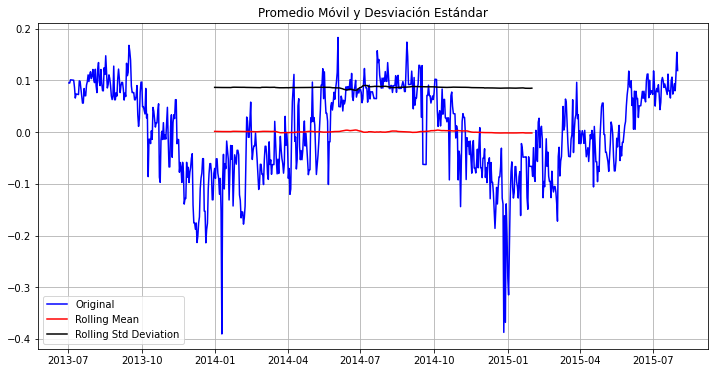

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                  -2.019765
p-value                          0.277975
#Lags Used                      12.000000
Number of Observations Used    748.000000
Critical Value (1%)             -3.439123
Critical Value (5%)             -2.865412
Critical Value (10%)            -2.568832
dtype: float64


In [ ]:
#AHORA LA ESTACIONARIDAD ESTARA ESCALADA EN LOG
test_stationarity(ts_test_log_moving_ave_diff)


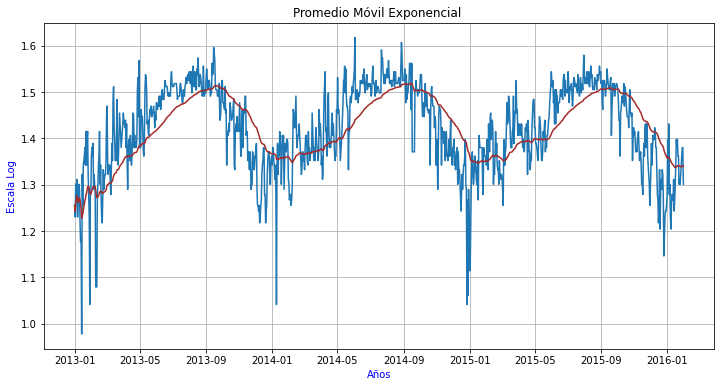

In [ ]:
# REPETIREMOS EL CALCULO USANDO PROMEDIOS MOVILES EXPONENCIALES,
# EL PARAMETRO "HALFLIFE" REPRESENTA EL NUMERO DE DIAS QUE TIENE CIERTA INFLUENCIA
# EN EL PROMEDIO, PERO SU INFLUENCIA CAE EXPONENCIALMENTE.  

EWM_avg = ts_test_log.ewm(halflife=30).mean()
plt.plot(ts_test_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();


In [ ]:
ts_test_log_EWM_avg_diff = ts_test_log - EWM_avg
EWM_avg.head()

Fecha
2013-01-01    1.255273
2013-01-02    1.242717
2013-01-03    1.262606
2013-01-04    1.266784
2013-01-05    1.276198
Name: Tmax, dtype: float64

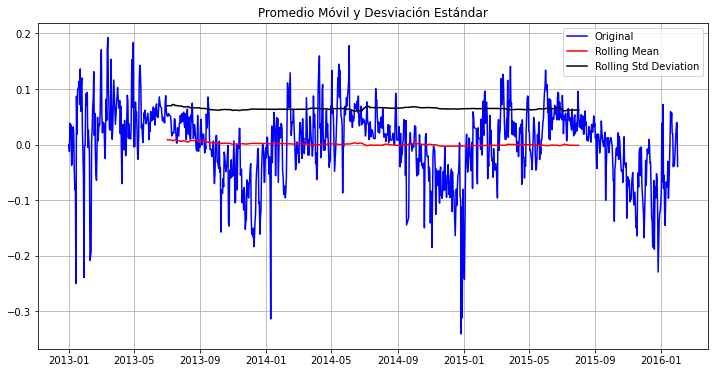

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.087442
p-value                           0.027497
#Lags Used                       14.000000
Number of Observations Used    1110.000000
Critical Value (1%)              -3.436255
Critical Value (5%)              -2.864147
Critical Value (10%)             -2.568158
dtype: float64


In [ ]:
test_stationarity(ts_test_log_EWM_avg_diff)


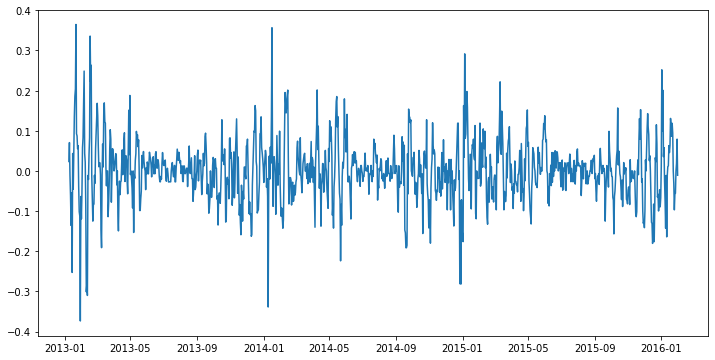

In [ ]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
plt.plot(ts_test_log_diff);

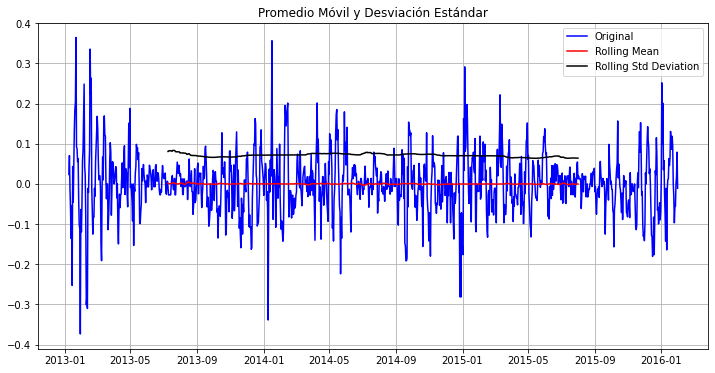

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -7.134984e+00
p-value                        3.439619e-10
#Lags Used                     2.200000e+01
Number of Observations Used    1.095000e+03
Critical Value (1%)           -3.436336e+00
Critical Value (5%)           -2.864183e+00
Critical Value (10%)          -2.568177e+00
dtype: float64


In [ ]:

# Probamos la estacionaridad
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

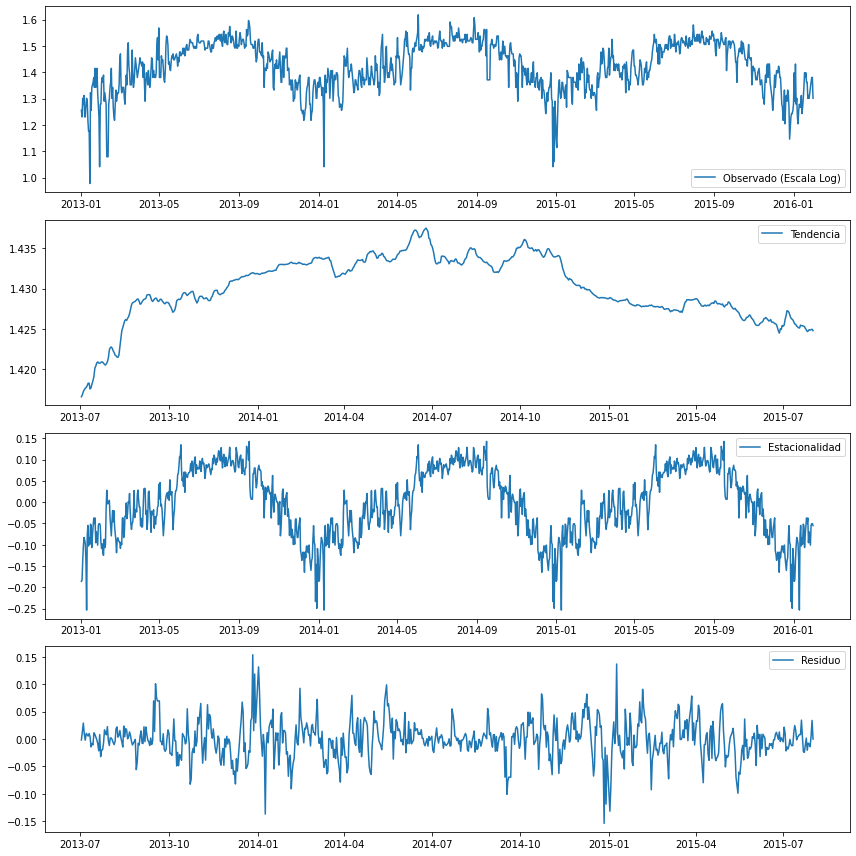

In [ ]:
# Método de descomposición usando la biblioteca statsmodels.tsa

des = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = des.trend
seasonal = des.seasonal
residue = des.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

plt.tight_layout();

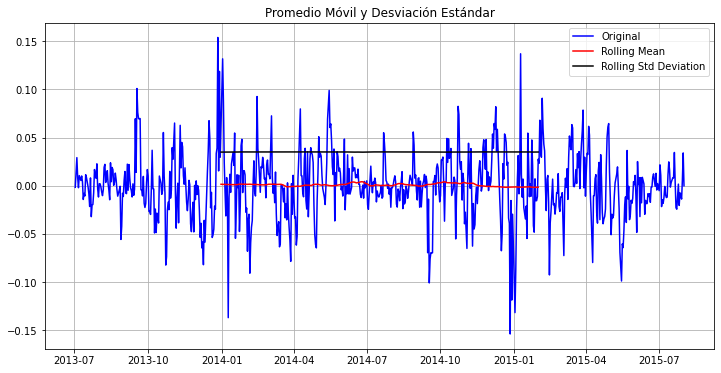

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -6.675742e+00
p-value                        4.470068e-09
#Lags Used                     1.900000e+01
Number of Observations Used    7.410000e+02
Critical Value (1%)           -3.439206e+00
Critical Value (5%)           -2.865448e+00
Critical Value (10%)          -2.568851e+00
dtype: float64


In [ ]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

In [ ]:
# Esta serie es estacionaria porque la prueba da un valor de p < 0.05 (4.47 x 10^(-09)).
# Podemos afirmar que es una serie de tiempo estacionaria con mas de un 99% de confianza.

# **PRUEBA AUMENTADA DE DICKEY-FULLER (ADF) TMIN**

In [ ]:
# DEFINIMOS LA SEIRE DE TIEMPO PARA TMIN QUE VAMOS A ESTUDIAR.
# DEFINIDA CON NOMBRE GENERICO.

ts_test2 = ts_90['Tmin'].copy()

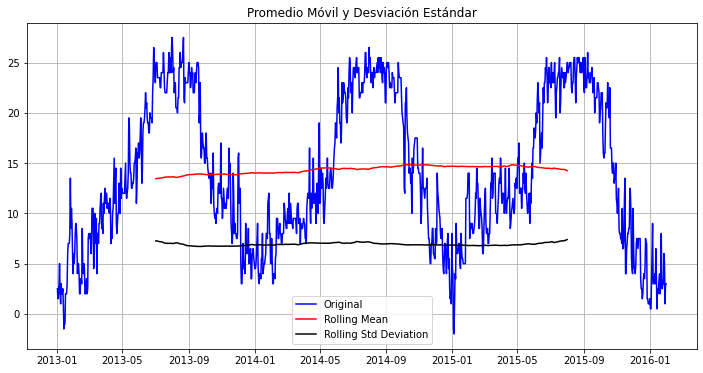

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -1.962357
p-value                           0.303318
#Lags Used                       19.000000
Number of Observations Used    1105.000000
Critical Value (1%)              -3.436282
Critical Value (5%)              -2.864159
Critical Value (10%)             -2.568165
dtype: float64


In [ ]:
#PRUEBA DE ESTACIONARIDAD DE TMIN
test_stationarity(ts_test2)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


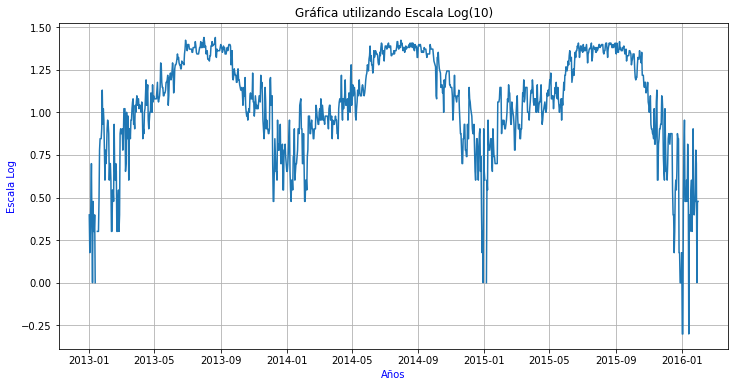

In [ ]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test2_log = np.log10(ts_test2)
plt.plot(ts_test2_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

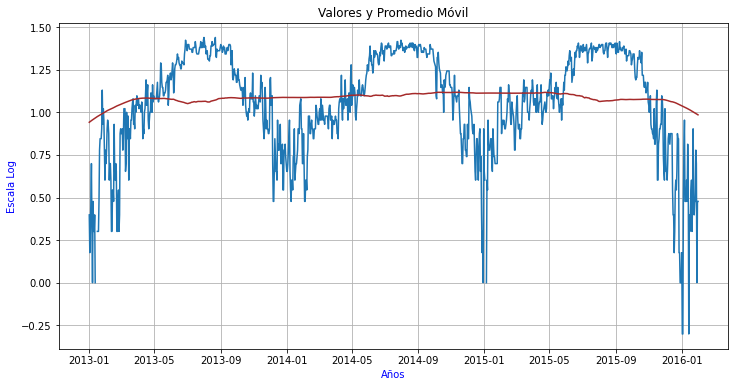

In [ ]:
# VAMOS A CALCULAR EL PROMEDIO MOVIL DE ts_test2_log CON VENTANA DE 365
# PARA VER EL CONTRASTE CON LA DE ARRIBA.

moving2_avg = ts_test2_log.rolling(365, center=True,min_periods=1).mean()
plt.plot(ts_test2_log)
plt.plot(moving2_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [ ]:
ts_test2_log_moving2_ave_diff = ts_test2_log - moving2_avg 
ts_test2_log_moving2_ave_diff.head()

Fecha
2013-01-01   -0.543616
2013-01-02   -0.767986
2013-01-03   -0.645541
2013-01-04   -0.471769
2013-01-05   -0.252215
Name: Tmin, dtype: float64

In [ ]:
ts_test2_log_moving2_ave_diff.dropna(inplace=True)
ts_test2_log_moving2_ave_diff.head()

Fecha
2013-01-01   -0.543616
2013-01-02   -0.767986
2013-01-03   -0.645541
2013-01-04   -0.471769
2013-01-05   -0.252215
Name: Tmin, dtype: float64

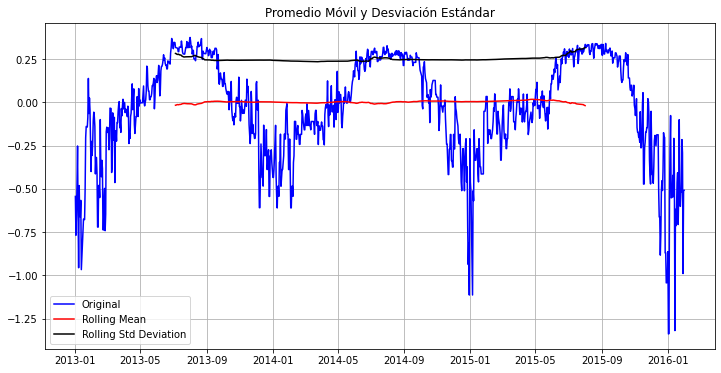

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.204721
p-value                           0.204536
#Lags Used                       18.000000
Number of Observations Used    1101.000000
Critical Value (1%)              -3.436303
Critical Value (5%)              -2.864169
Critical Value (10%)             -2.568170
dtype: float64


In [ ]:
#AHORA LA ESTACIONARIDAD ESTARA ESCALADA EN LOG
test_stationarity(ts_test2_log_moving2_ave_diff)

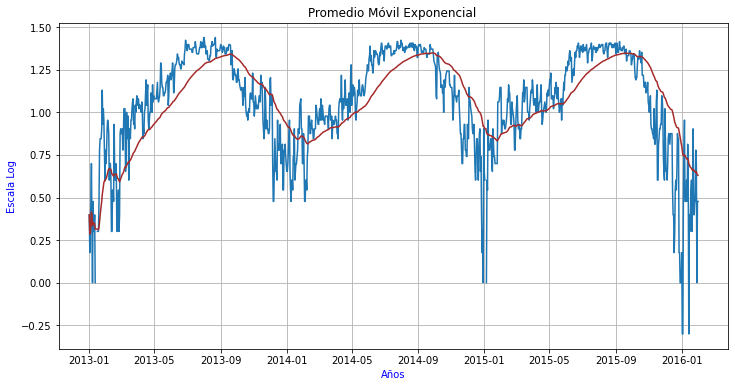

In [ ]:
# REPETIREMOS EL CALCULO USANDO PROMEDIOS MOVILES EXPONENCIALES,
# EL PARAMETRO "HALFLIFE" REPRESENTA EL NUMERO DE DIAS QUE TIENE CIERTA INFLUENCIA
# EN EL PROMEDIO, PERO SU INFLUENCIA CAE EXPONENCIALMENTE.  

EWM2_avg = ts_test2_log.ewm(halflife=30).mean()
plt.plot(ts_test2_log)
plt.plot(EWM2_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();


In [ ]:
ts_test2_log_EWM2_avg_diff = ts_test2_log - EWM2_avg
EWM2_avg.head()

Fecha
2013-01-01    0.397940
2013-01-02    0.285734
2013-01-03    0.290951
2013-01-04    0.339119
2013-01-05    0.414453
Name: Tmin, dtype: float64

In [ ]:
ts_test2_log_EWM2_avg_diff.dropna(inplace=True)
ts_test2_log_EWM2_avg_diff.head()

Fecha
2013-01-01    0.000000
2013-01-02   -0.109643
2013-01-03    0.010079
2013-01-04    0.138002
2013-01-05    0.284517
Name: Tmin, dtype: float64

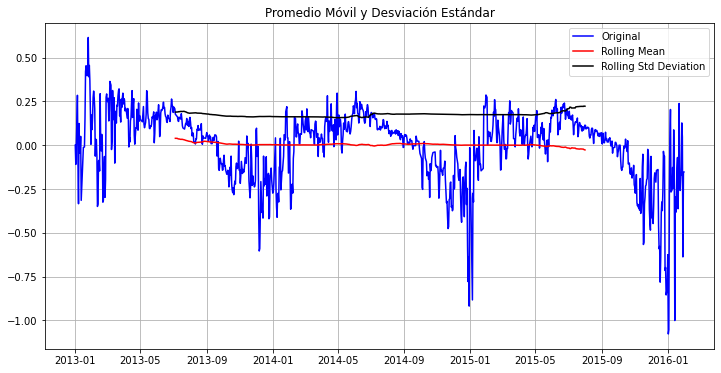

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.912364
p-value                           0.043929
#Lags Used                       21.000000
Number of Observations Used    1098.000000
Critical Value (1%)              -3.436320
Critical Value (5%)              -2.864176
Critical Value (10%)             -2.568173
dtype: float64


In [ ]:
test_stationarity(ts_test2_log_EWM2_avg_diff)

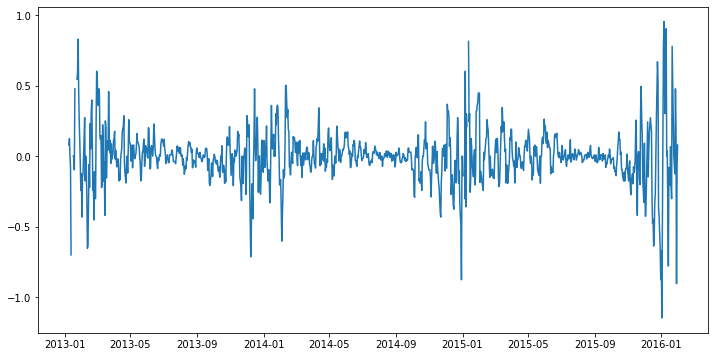

In [ ]:
# Diferenciamos usando la función df.shift()
ts_test2_log_diff = ts_test2_log - ts_test2_log.shift(periods=7)
plt.plot(ts_test2_log_diff);

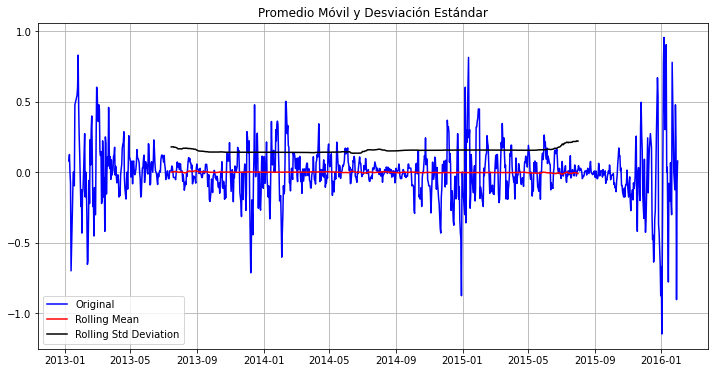

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -6.784725e+00
p-value                        2.448599e-09
#Lags Used                     2.200000e+01
Number of Observations Used    1.085000e+03
Critical Value (1%)           -3.436391e+00
Critical Value (5%)           -2.864207e+00
Critical Value (10%)          -2.568190e+00
dtype: float64


In [ ]:
# Probamos la estacionaridad
ts_test2_log_diff.dropna(inplace=True)
test_stationarity(ts_test2_log_diff)

In [ ]:
# Esta serie es estacionaria porque la prueba da un valor de p < 0.05 (2.44 x 10^(-09)).
# Podemos afirmar que es una serie de tiempo estacionaria con mas de un 99% de confianza.

# **PRUEBA AUMENTADA DE ARIMA TMAX**

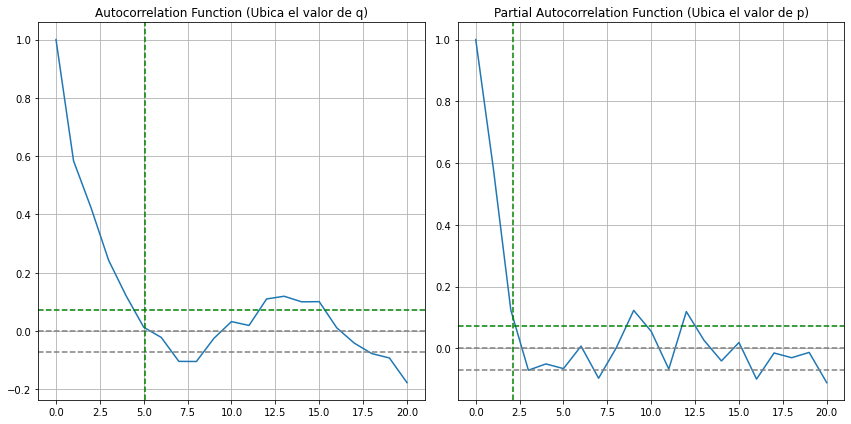

In [ ]:
#Aplicamos ARIMA

lag_acf = acf(ts_test_log_decompose, nlags=20)
lag_pacf = pacf(ts_test_log_decompose, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_decompose)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_decompose)), linestyle='--', color='green')

# Graficamos unas líneas verticales como referencias
plt.axvline(x=5.1, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_decompose)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_decompose)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2.1, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

In [ ]:
# EL VALOR DE q DEBE DE SER 5.1 POR QUE CRUZA POR PRIMERA VEZ EN EL VALOR MAXIMO
# EN CUANTO EL VALOR DE p DEBE DE SER 2.1

# PERO COMO LA BIBLIOTECA UTILIZA NUMEROS ENTEROS, REDONDEAREMOS
# q = 5
# p = 2

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1124
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1885.458
Method:                       css-mle   S.D. of innovations              0.045
Date:                Wed, 17 Feb 2021   AIC                          -3762.916
Time:                        17:59:28   BIC                          -3742.818
Sample:                             1   HQIC                         -3755.321
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         6.189e-05      0.001      0.062      0.951      -0.002       0.002
ar.L1.D.Tmax    -0.2902      0.030     -9.732      0.000      -0.349      -0.232
ar.L2.D.Tmax    -0.0520      0.030     -1.74

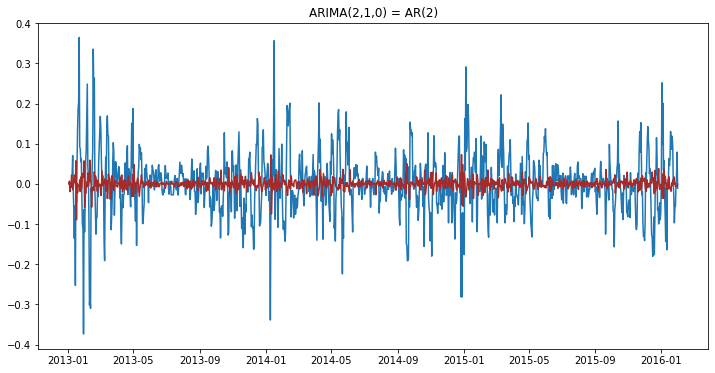

In [ ]:
# MODELO AR ( AUTO-REGRESION )
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1124
Model:                 ARIMA(0, 1, 4)   Log Likelihood                1945.587
Method:                       css-mle   S.D. of innovations              0.043
Date:                Wed, 17 Feb 2021   AIC                          -3879.173
Time:                        17:59:29   BIC                          -3849.025
Sample:                             1   HQIC                         -3867.780
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.768e-05      0.000      0.209      0.834      -0.000       0.001
ma.L1.D.Tmax    -0.4076      0.029    -13.962      0.000      -0.465      -0.350
ma.L2.D.Tmax    -0.0633      0.031     -2.03

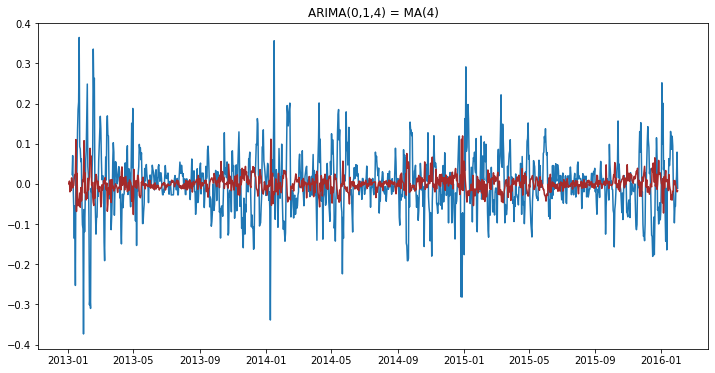

In [ ]:
# MODELO MA ( PROMEDIO MOVIL )
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1124
Model:                 ARIMA(2, 1, 5)   Log Likelihood                1948.147
Method:                       css-mle   S.D. of innovations              0.043
Date:                Wed, 17 Feb 2021   AIC                          -3878.294
Time:                        17:59:33   BIC                          -3833.072
Sample:                             1   HQIC                         -3861.205
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.734e-05      0.000      0.211      0.833      -0.000       0.001
ar.L1.D.Tmax     0.0695      0.492      0.141      0.888      -0.894       1.033
ar.L2.D.Tmax    -0.2349      0.263     -0.89

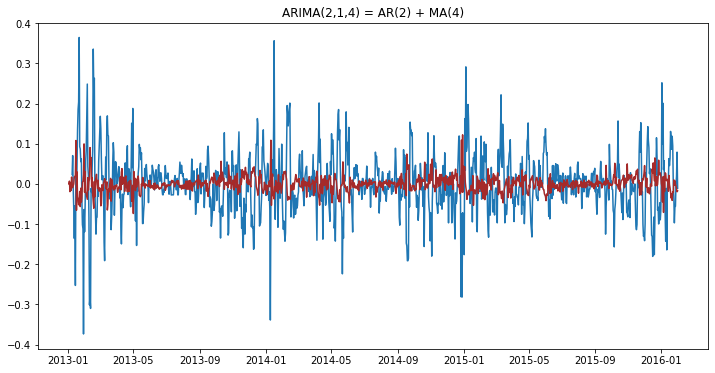

In [ ]:
# MODELO DE ARIMA (AUTO-REGRESION + PROMEDIO MOVIL)
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log, order=(2,1,5), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

In [ ]:
# AIC PARA EL MODELO AR    =                          -3762.916
# AIC PARA EL MODELO AM    =                          -3879.173
# AIC PARA EL MODELO ARIMA =                          -3888.294

# Podemos afirmar que ARIMA (2,1,4) es el mejor modelo de los 3 que exploramos.
# YA QUE EL AIC ES EL MENOR.



In [ ]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
2013-01-02    0.000057
2013-01-03    0.006959
2013-01-04   -0.019197
2013-01-05    0.003209
2013-01-06   -0.016302
                ...   
2016-01-27   -0.000832
2016-01-28   -0.004676
2016-01-29   -0.012897
2016-01-30   -0.019381
2016-01-31   -0.017187
Length: 1124, dtype: float64


In [ ]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
2013-01-01         NaN
2013-01-02    1.230506
2013-01-03    1.307989
2013-01-04    1.259556
2013-01-05    1.314963
dtype: float64
Fecha
2016-01-27    1.341591
2016-01-28    1.357052
2016-01-29    1.367314
2016-01-30    1.360830
2016-01-31    1.283843
dtype: float64


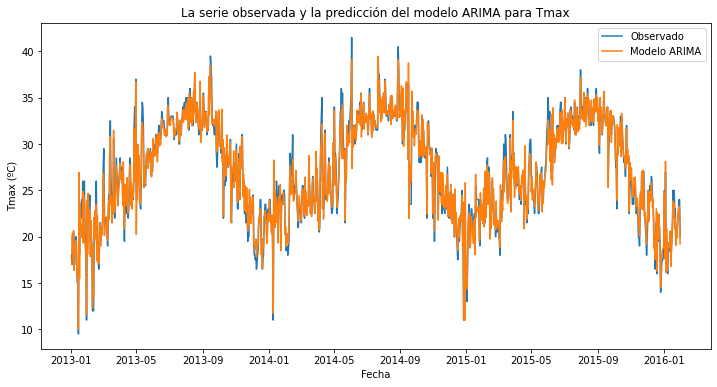

In [ ]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [ ]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 1.1179036715019783


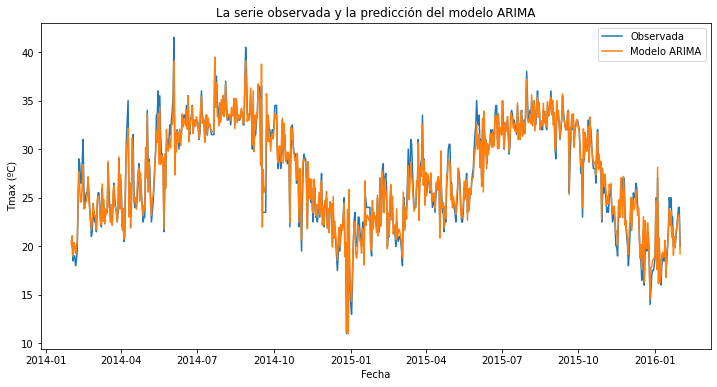

In [ ]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_test.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

# **PRUEBA AUMENTADA DE ARIMA TMIN**

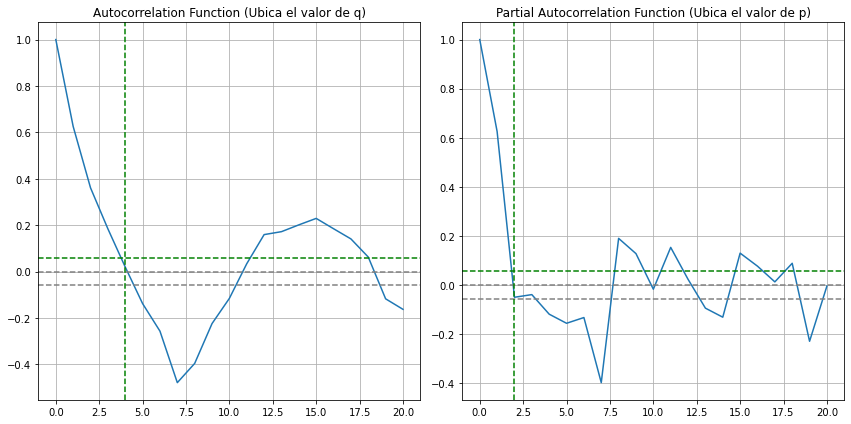

In [ ]:
#Aplicamos ARIMA

lag_acf = acf(ts_test2_log_diff, nlags=20)
lag_pacf = pacf(ts_test2_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test2_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test2_log_diff)), linestyle='--', color='green')

# Graficamos unas líneas verticales como referencias
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test2_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test2_log_diff)), linestyle='--', color='green')

# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

In [ ]:
# EL VALOR DE q DEBE DE SER 4 POR QUE CRUZA POR PRIMERA VEZ EN EL VALOR MAXIMO
# EN CUANTO EL VALOR DE p DEBE DE SER 2

# PERO COMO LA BIBLIOTECA UTILIZA NUMEROS ENTEROS, REDONDEAREMOS
# q = 4
# p = 2

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 1119
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 860.921
Method:                       css-mle   S.D. of innovations              0.112
Date:                Wed, 17 Feb 2021   AIC                          -1713.841
Time:                        17:59:36   BIC                          -1693.761
Sample:                             1   HQIC                         -1706.251
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.563e-05      0.002      0.024      0.981      -0.005       0.005
ar.L1.D.Tmin    -0.2279      0.029     -7.761      0.000      -0.285      -0.170
ar.L2.D.Tmin    -0.1966      0.030     -6.64

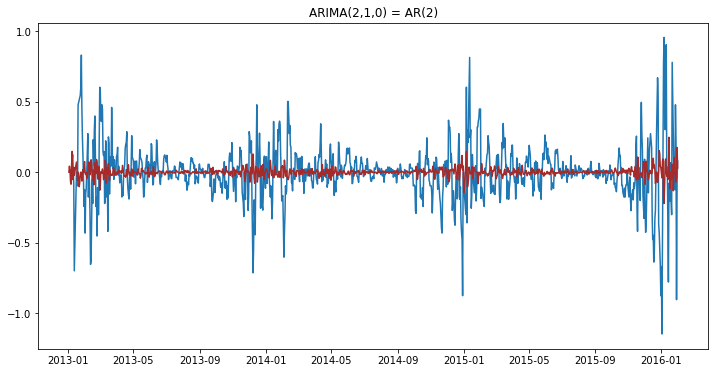

In [ ]:
# MODELO AR ( AUTO-REGRESION )
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test2_log, order=(2,1,0), missing='drop')
results_AR2 = model.fit(displ=-1)
plt.plot(ts_test2_log_diff)
plt.plot(results_AR2.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR2.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 1119
Model:                 ARIMA(0, 1, 4)   Log Likelihood                 893.539
Method:                       css-mle   S.D. of innovations              0.109
Date:                Wed, 17 Feb 2021   AIC                          -1775.078
Time:                        17:59:36   BIC                          -1744.957
Sample:                             1   HQIC                         -1763.692
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         8.997e-05      0.001      0.087      0.930      -0.002       0.002
ma.L1.D.Tmin    -0.3058      0.030    -10.251      0.000      -0.364      -0.247
ma.L2.D.Tmin    -0.2148      0.031     -6.92

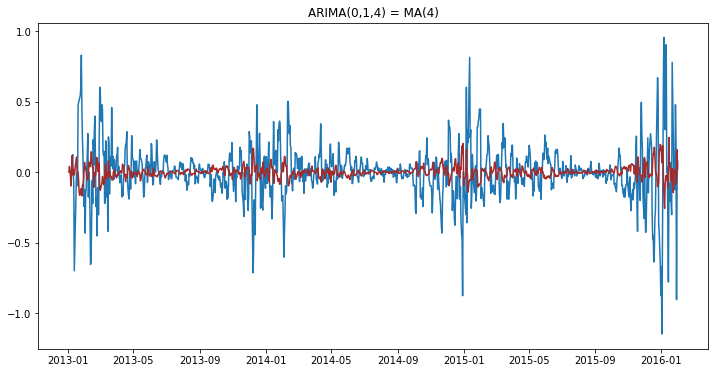

In [ ]:
# MODELO MA ( PROMEDIO MOVIL )
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test2_log, order=(0,1,4), missing='drop')
results_MA2 = model.fit(displ=-1)
plt.plot(ts_test2_log_diff)
plt.plot(results_MA2.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA2.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 1119
Model:                 ARIMA(2, 1, 4)   Log Likelihood                 896.265
Method:                       css-mle   S.D. of innovations              0.109
Date:                Wed, 17 Feb 2021   AIC                          -1776.530
Time:                        17:59:39   BIC                          -1736.369
Sample:                             1   HQIC                         -1761.350
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         6.769e-05      0.001      0.071      0.943      -0.002       0.002
ar.L1.D.Tmin     0.1279      0.289      0.443      0.658      -0.438       0.693
ar.L2.D.Tmin     0.3313      0.168      1.97

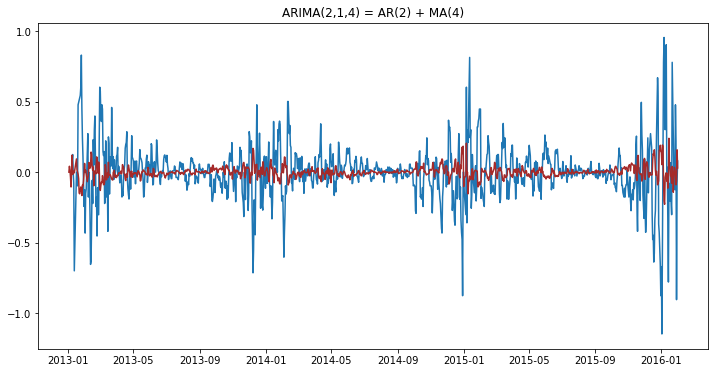

In [ ]:
# MODELO DE ARIMA (AUTO-REGRESION + PROMEDIO MOVIL)
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test2_log, order=(2,1,4), missing='drop')
results_ARIMA2 = model.fit(displ=-1)
plt.plot(ts_test2_log_diff)
plt.plot(results_ARIMA2.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA2.summary())

In [ ]:
# AIC PARA EL MODELO AR    =                          -1713.841
# AIC PARA EL MODELO AM    =                          -1775.078
# AIC PARA EL MODELO ARIMA =                          -1776.530

# Podemos afirmar que ARIMA (2,1,4) es el mejor modelo de los 3 que exploramos.
# YA QUE EL AIC ES EL MENOR.

In [ ]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions2_ARIMA_diff = pd.Series(results_ARIMA2.fittedvalues, copy=True)
print(predictions2_ARIMA_diff)

Fecha
2013-01-02    0.000068
2013-01-03    0.041823
2013-01-04    0.013925
2013-01-05   -0.037158
2013-01-06   -0.104935
                ...   
2016-01-27   -0.004370
2016-01-28   -0.089565
2016-01-29   -0.065015
2016-01-30    0.158188
2016-01-31    0.029766
Length: 1119, dtype: float64


In [ ]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions2_ARIMA_log = pd.Series(ts_test2_log, index = ts_test2_log.index)
predictions2_ARIMA_log = predictions2_ARIMA_log.add(predictions2_ARIMA_diff)
print(predictions2_ARIMA_log.head())
print(predictions2_ARIMA_log.tail())

Fecha
2013-01-01         NaN
2013-01-02    0.176159
2013-01-03    0.342853
2013-01-04    0.491046
2013-01-05    0.661812
dtype: float64
Fecha
2016-01-27    0.773781
2016-01-28    0.609405
2016-01-29   -0.065015
2016-01-30    0.635310
2016-01-31    0.506887
dtype: float64


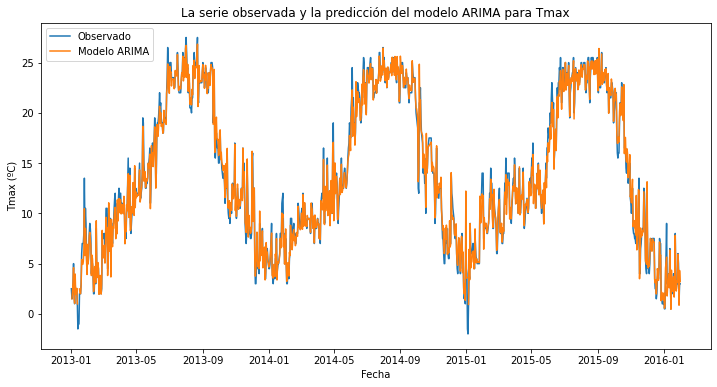

In [ ]:
# Regresamos a la escala de Temperatura original 
predictions2_ARIMA = 10**(predictions2_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test2, label='Observado');
plt.plot(predictions2_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [ ]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions2_ARIMA - ts_test2)**2))
print('RMSE:', RMSE)

RMSE: 0.7897237649950264


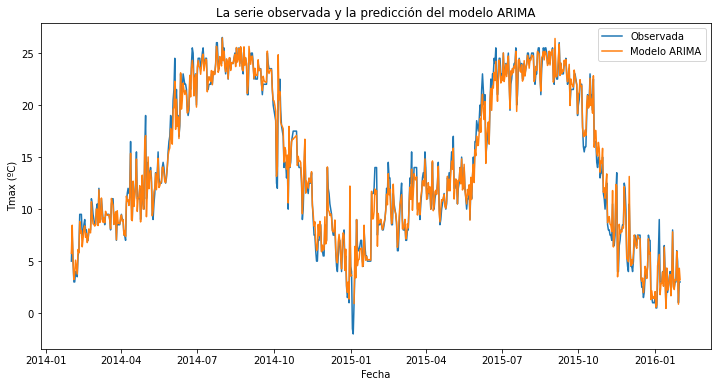

In [ ]:
# Graficamos sólo los útimos datos de las series 
ts_test2_last = ts_test2.tail(730)
predictions2_ARIMA_last = predictions2_ARIMA.tail(730)
plt.plot(ts_test2_last, label='Observada');
plt.plot(predictions2_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');